<a href="https://colab.research.google.com/github/Nysakun/Stock-Price-Prediction/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install necessary libraries
# yfinance is for downloading stock data from Yahoo Finance
# tensorflow is for building our LSTM model
!pip install yfinance tensorflow

In [2]:
# Cell 2: Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Set style
sns.set_style("whitegrid")
print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Cell 3: Download Stock Data
# We'll download 10 years of Apple (AAPL) stock data
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2024-12-31' # Use a recent-ish end date

try:
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        print(f"No data found for ticker {ticker}.")
    else:
        print("Data downloaded successfully!")
        print(data.head())
except Exception as e:
    print(f"Error downloading data: {e}")

/tmp/ipython-input-2176335967.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data downloaded successfully!
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261044  24.729267  23.821668  24.718171  212818400
2015-01-05  23.577568  24.110144  23.391167  24.030258  257142000
2015-01-06  23.579794  23.839424  23.218085  23.641928  263188400
2015-01-07  23.910435  24.010292  23.677432  23.788385  160423600
2015-01-08  24.829128  24.886824  24.121246  24.238858  237458000


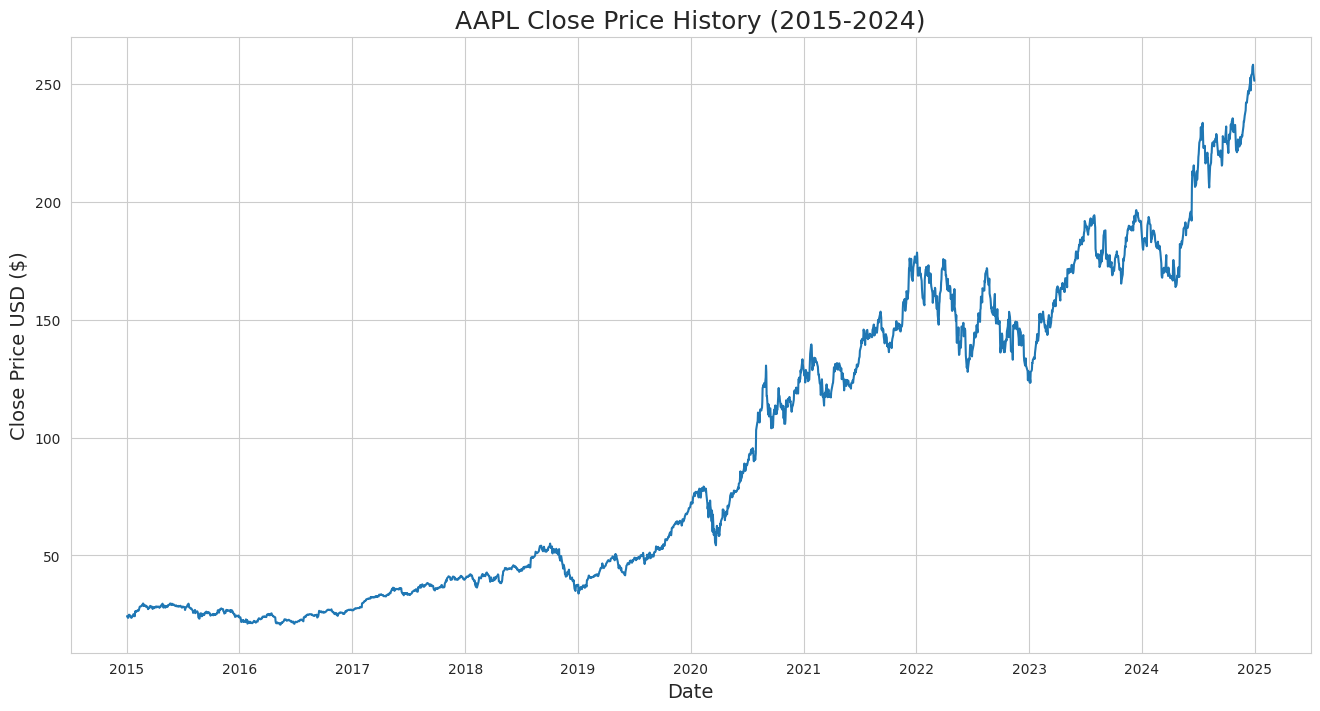

In [4]:
# Cell 4: Plot the Closing Price History
if 'data' in locals() and not data.empty:
    plt.figure(figsize=(16, 8))
    plt.title(f'{ticker} Close Price History (2015-2024)', fontsize=18)
    plt.plot(data['Close'])
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Close Price USD ($)', fontsize=14)
    plt.show()

In [6]:
# Cell 5: Prepare Data for LSTM
if 'data' in locals() and not data.empty:
    # 1. We only need the 'Close' column
    # Access 'Close' column using the multi-level index
    df_close = data[('Close', 'AAPL')]
    dataset = df_close.values.reshape(-1, 1)  # Convert to numpy array and reshape

    # 2. Define training data size (80% of data)
    training_data_len = int(np.ceil(len(dataset) * 0.8))

    # 3. Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    print(f"Total data points: {len(dataset)}")
    print(f"Training data points: {training_data_len}")
    print(f"Test data points: {len(dataset) - training_data_len}")

Total data points: 2515
Training data points: 2012
Test data points: 503


In [7]:
# Cell 6: Create the Training Data Sequences
if 'scaled_data' in locals():
    # 1. Create the scaled training dataset
    train_data = scaled_data[0:training_data_len, :]

    # 2. Split into x_train and y_train
    x_train = []
    y_train = []

    lookback = 60  # We'll use 60 days of history to predict the next day

    for i in range(lookback, len(train_data)):
        # x_train will contain 60 values (i-60 to i-1)
        x_train.append(train_data[i-lookback:i, 0])
        # y_train will contain the 61st value (i)
        y_train.append(train_data[i, 0])

    # Convert to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # 3. Reshape the data (LSTMs need 3D input: [samples, timesteps, features])
    # Samples: Number of data points (rows)
    # Timesteps: Length of our lookback (60)
    # Features: Number of features (just 'Close' price, so 1)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    print(f"x_train shape: {x_train.shape}")
    print(f"y_train shape: {y_train.shape}")

x_train shape: (1952, 60, 1)
y_train shape: (1952,)


In [8]:
# Cell 7: Build the LSTM Model Architecture
if 'x_train' in locals():
    model = Sequential()

    # Layer 1: 64 units, return sequences because we will stack another layer
    model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2)) # Prevent overfitting

    # Layer 2: 64 units, return_sequences=False because it's the last LSTM layer
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))

    # Layer 3: A dense layer to consolidate
    model.add(Dense(32))

    # Layer 4: Output layer (predicts the single 'Close' price)
    model.add(Dense(1))

    # Compile the model
    # Optimizer 'adam' is a good default
    # Loss 'mean_squared_error' is standard for regression problems
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Cell 8: Train the Model
# This step will take a few minutes!
if 'model' in locals():
    print("Training model... This may take a few minutes.")
    history = model.fit(
        x_train,
        y_train,
        batch_size=32,
        epochs=25
    )
    print("Model training complete!")

Training model... This may take a few minutes.
Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0097
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 9.6245e-04
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 8.7021e-04
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 8.3422e-04
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.3180e-04
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 6.8943e-04
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 5.7965e-04
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 6.1287e-04
Epoch 9/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 5.3849e-04
Epoch 10/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 5.0846e-04
Epoch 11/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.5794e-04
Epoch 12/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.7914e-04
Epoch 13/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 4.5757e-04
Epoch 14/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 3

In [10]:
# Cell 9: Create the Test Dataset
if 'model' in locals():
    # 1. Get the test data
    test_data = scaled_data[training_data_len - lookback:, :]

    # 2. Create x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]  # Actual, unscaled values

    for i in range(lookback, len(test_data)):
        x_test.append(test_data[i-lookback:i, 0])

    # Convert to numpy array
    x_test = np.array(x_test)

    # Reshape for LSTM
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    print(f"x_test shape: {x_test.shape}")
    print(f"y_test shape: {y_test.shape}")

x_test shape: (503, 60, 1)
y_test shape: (503, 1)


In [11]:
# Cell 10: Get Model's Predictions
if 'x_test' in locals():
    # 1. Get the predicted values (will be scaled 0-1)
    predictions = model.predict(x_test)

    # 2. "Un-scale" the predictions back to actual dollar values
    predictions = scaler.inverse_transform(predictions)

    # 3. Calculate RMSE (Root Mean Squared Error)
    # This is a metric of how "wrong" our model is on average
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(f"\nRoot Mean Squared Error (RMSE): {rmse:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Root Mean Squared Error (RMSE): 6.17


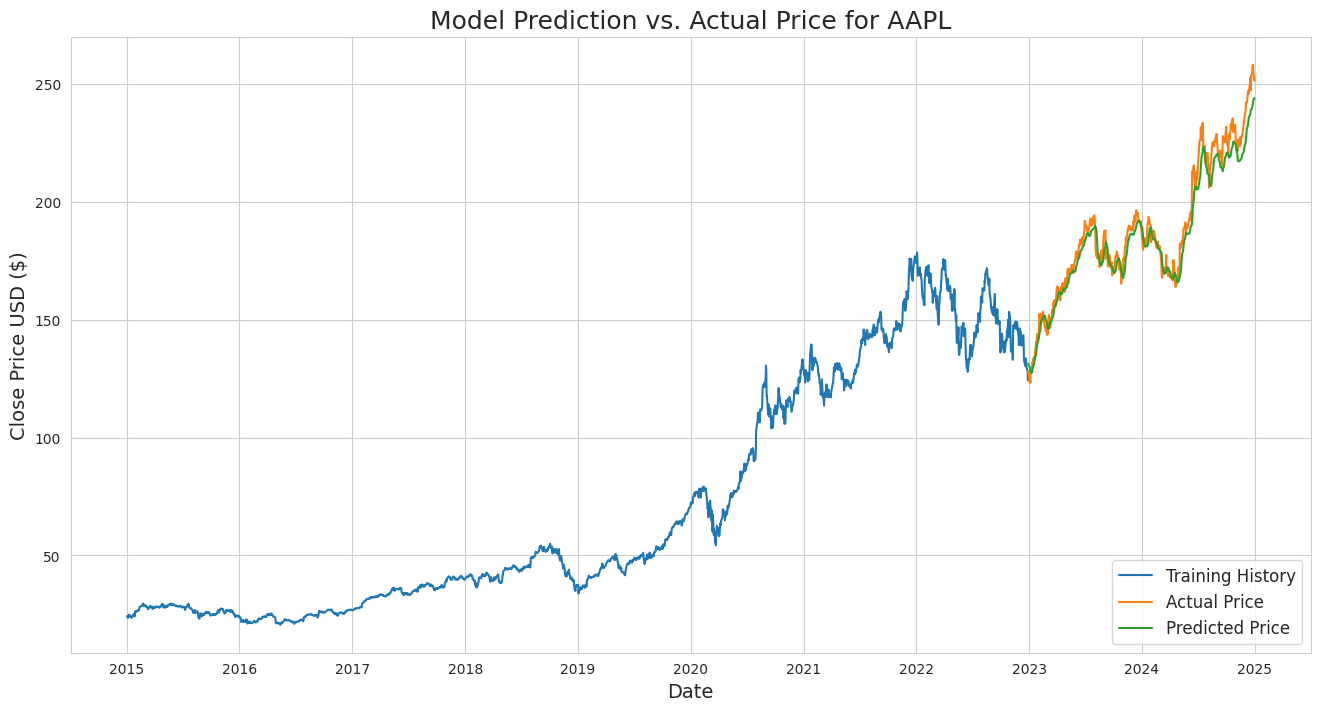

In [13]:
# Cell 11: Plot the Results
if 'predictions' in locals():
    # 1. Create dataframes for plotting
    train = df_close[:training_data_len].reset_index()
    valid = df_close[training_data_len:].reset_index()
    valid['Predictions'] = predictions # Add our predictions to the dataframe

    # Rename the column containing the close price to 'Close'
    train.rename(columns={train.columns[1]: 'Close'}, inplace=True)
    valid.rename(columns={valid.columns[1]: 'Close'}, inplace=True)

    # 2. Create the plot
    plt.figure(figsize=(16, 8))
    plt.title(f'Model Prediction vs. Actual Price for {ticker}', fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Close Price USD ($)', fontsize=14)

    # Plot training data (blue)
    plt.plot(train['Date'], train['Close'], label='Training History')
    # Plot actual test data (orange)
    plt.plot(valid['Date'], valid['Close'], label='Actual Price')
    # Plot predicted test data (green)
    plt.plot(valid['Date'], valid['Predictions'], label='Predicted Price')

    plt.legend(loc='lower right', fontsize=12)
    plt.show()